# Model Training and Evaluation

## Step 1: Import necessary libraries


In [84]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

## Step 2: Data Loading


In [85]:
# Load the dataset
df = pd.read_csv("../Dataset/sp500_for_train.csv", index_col='Symbol')
df.head()

,Industry,Currentprice,City,Fulltimeemployees,Weight,Growth_Category,Growth_Category_numeric,Industry_te,City_te,Log_Currentprice,Log_Employees,Price_per_employee,Log_PPE,Employees_per_million_usd,Is_large_employer,Is_expensive_stock,City_Industry_combo
Symbol,,,,,,,,,,,,,,,,,
AAPL,Consumer Electronics,254.49,Cupertino,164000.0,0.069209,Moderate Growth,2,1.460922,1.460922,5.543183,12.007628,0.001552,0.001551,641.903793,1,1,2.134293
NVDA,Semiconductors,134.70,Santa Clara,29600.0,0.059350,Hyper Growth,4,1.400000,1.857143,4.910447,10.295563,0.004551,0.004540,218.128224,1,1,2.600000
MSFT,Software - Infrastructure,436.60,Redmond,228000.0,0.058401,High Growth,3,2.090909,1.460922,6.081305,12.337105,0.001915,0.001913,521.023766,1,1,3.054655
AMZN,Internet Retail,224.92,Seattle,1551000.0,0.042550,Moderate Growth,2,1.460922,1.400000,5.420181,14.254411,0.000145,0.000145,6865.262040,1,1,2.045291
GOOGL,Internet Content & Information,191.41,Mountain View,181269.0,0.042309,High Growth,3,2.333333,3.500000,5.259629,12.107743,0.001056,0.001055,942.097604,1,1,8.166667


In [86]:
# Split the data into features and target variable
features = [
    'Industry_te', 'City_te', 'Log_Currentprice', 'Log_Employees', 'Log_PPE',
    'Employees_per_million_usd', 'Is_large_employer', 'Is_expensive_stock', 'City_Industry_combo'
]
X = df[features]
y = df['Growth_Category_numeric']


## Step 3: Train-Test Split


In [87]:
# Split the data into features and target variable
features = [
    'Industry_te', 'City_te', 'Log_Currentprice', 'Log_Employees', 'Log_PPE',
    'Employees_per_million_usd', 'Is_large_employer', 'Is_expensive_stock', 'City_Industry_combo'
]
X = df[features]
y = df['Growth_Category_numeric']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4])

## Step 4: Hyperparameter Tuning 


In [88]:
# Logistic Regression
gs_lr = GridSearchCV(LogisticRegression(max_iter=5000), {'C': [0.01, 0.1, 1, 10]}, scoring='f1_macro', cv=3)
gs_lr.fit(X_train, y_train)
print("\n[LogReg] Best Params:", gs_lr.best_params_, "Best F1:", gs_lr.best_score_)


[LogReg] Best Params: {'C': 1} Best F1: 0.27240457273774116


In [89]:
# k-NN
gs_knn = GridSearchCV(KNeighborsClassifier(), {'n_neighbors': [3, 5, 7]}, scoring='f1_macro', cv=3)
gs_knn.fit(X_train, y_train)
print("\n[k-NN] Best Params:", gs_knn.best_params_, "Best F1:", gs_knn.best_score_)


[k-NN] Best Params: {'n_neighbors': 5} Best F1: 0.2228525381108026


In [90]:
# Decision Tree
gs_dt = GridSearchCV(DecisionTreeClassifier(), {'max_depth': [3, 5, 10]}, scoring='f1_macro', cv=3)
gs_dt.fit(X_train, y_train)
print("\n[Decision Tree] Best Params:", gs_dt.best_params_, "Best F1:", gs_dt.best_score_)


[Decision Tree] Best Params: {'max_depth': 10} Best F1: 0.2883819079203897


In [91]:
# Random Forest
gs_rf = GridSearchCV(RandomForestClassifier(), {
    'n_estimators': [50, 100],
    'max_depth': [5, 10]
}, scoring='f1_macro', cv=3)
gs_rf.fit(X_train, y_train)
print("\n[Random Forest] Best Params:", gs_rf.best_params_, "Best F1:", gs_rf.best_score_)


[Random Forest] Best Params: {'max_depth': 10, 'n_estimators': 100} Best F1: 0.2980155951844809


## Step 5: Define Function for Model Evaluation and ROC


In [92]:
def evaluate_model(name, model, X_train, X_test, y_train, y_test, y_test_bin, scores_dict, roc_dict):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    scores_dict[name] = f1

    print(f"\n{name} Results:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    # Save plot to ../Image/
    save_dir = "../Image"
    os.makedirs(save_dir, exist_ok=True)
    filename = f"{name.replace(' ', '_').lower()}_confusion_matrix.png"
    plt.savefig(os.path.join(save_dir, filename))
    
    plt.show()

    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)
        roc_auc = roc_auc_score(y_test_bin, y_proba, multi_class='ovr')
        roc_dict[name] = roc_auc

## Step 6: Model Training and Comparison (After Tuning)



Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.52      0.44      0.48        27
           1       0.47      0.35      0.40        26
           2       0.43      0.70      0.53        33
           3       0.25      0.08      0.12        13
           4       0.00      0.00      0.00         1

    accuracy                           0.45       100
   macro avg       0.33      0.31      0.31       100
weighted avg       0.44      0.45      0.42       100



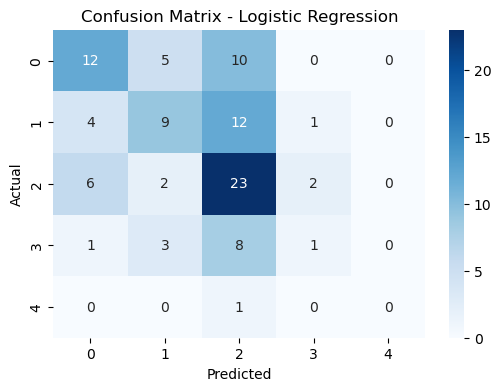


k-NN Results:
              precision    recall  f1-score   support

           0       0.34      0.41      0.37        27
           1       0.27      0.23      0.25        26
           2       0.36      0.42      0.39        33
           3       0.20      0.08      0.11        13
           4       0.00      0.00      0.00         1

    accuracy                           0.32       100
   macro avg       0.24      0.23      0.22       100
weighted avg       0.31      0.32      0.31       100



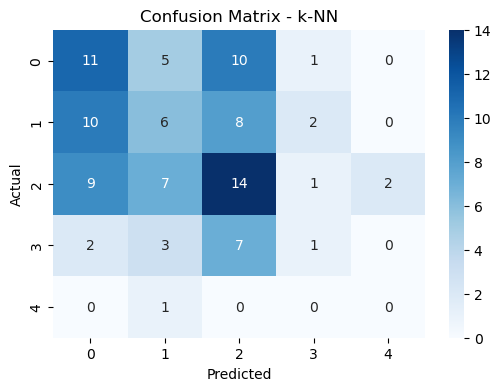


Decision Tree Results:
              precision    recall  f1-score   support

           0       0.47      0.33      0.39        27
           1       0.36      0.35      0.35        26
           2       0.44      0.48      0.46        33
           3       0.08      0.08      0.08        13
           4       0.12      1.00      0.22         1

    accuracy                           0.36       100
   macro avg       0.30      0.45      0.30       100
weighted avg       0.38      0.36      0.36       100



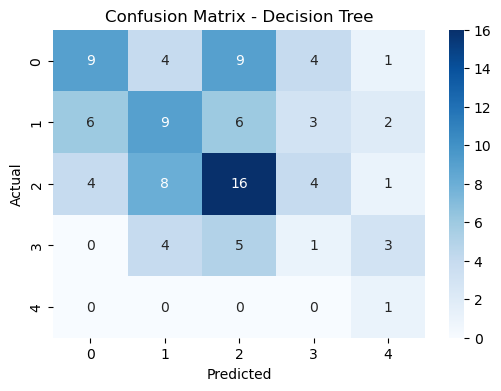


Random Forest Results:
              precision    recall  f1-score   support

           0       0.65      0.56      0.60        27
           1       0.55      0.46      0.50        26
           2       0.47      0.61      0.53        33
           3       0.30      0.23      0.26        13
           4       0.00      0.00      0.00         1

    accuracy                           0.50       100
   macro avg       0.39      0.37      0.38       100
weighted avg       0.51      0.50      0.50       100



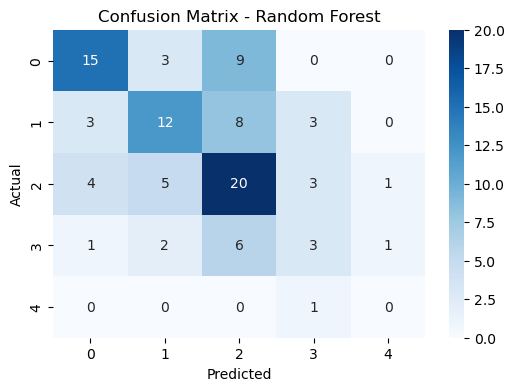


Naive Bayes Results:
              precision    recall  f1-score   support

           0       0.32      0.56      0.41        27
           1       0.32      0.23      0.27        26
           2       0.40      0.06      0.11        33
           3       0.24      0.54      0.33        13
           4       0.00      0.00      0.00         1

    accuracy                           0.30       100
   macro avg       0.26      0.28      0.22       100
weighted avg       0.33      0.30      0.26       100



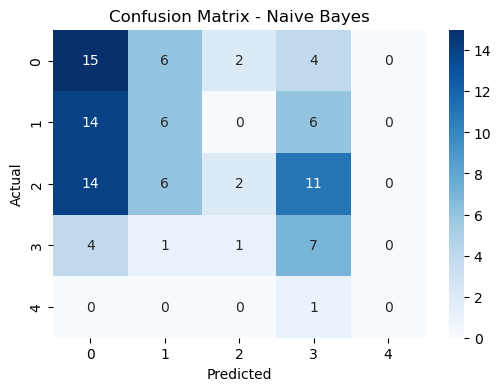


XGBoost Results:
              precision    recall  f1-score   support

           0       0.58      0.56      0.57        27
           1       0.52      0.46      0.49        26
           2       0.47      0.52      0.49        33
           3       0.27      0.23      0.25        13
           4       0.00      0.00      0.00         1

    accuracy                           0.47       100
   macro avg       0.37      0.35      0.36       100
weighted avg       0.48      0.47      0.48       100



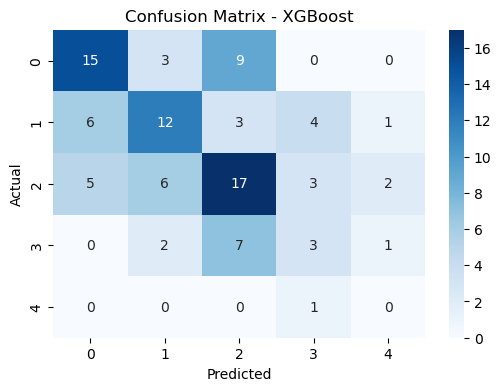

In [93]:
models = {
    'Logistic Regression': gs_lr.best_estimator_,
    'k-NN': gs_knn.best_estimator_,
    'Decision Tree': gs_dt.best_estimator_,
    'Random Forest': gs_rf.best_estimator_,
    'Naive Bayes': GaussianNB(),
    'XGBoost': xgb.XGBClassifier(objective='multi:softprob', num_class=5, eval_metric='mlogloss')
}

scores = {}
roc_aucs = {}

for name, model in models.items():
    evaluate_model(name, model, X_train, X_test, y_train, y_test, y_test_bin, scores, roc_aucs)

## Step 7: Results Visualization

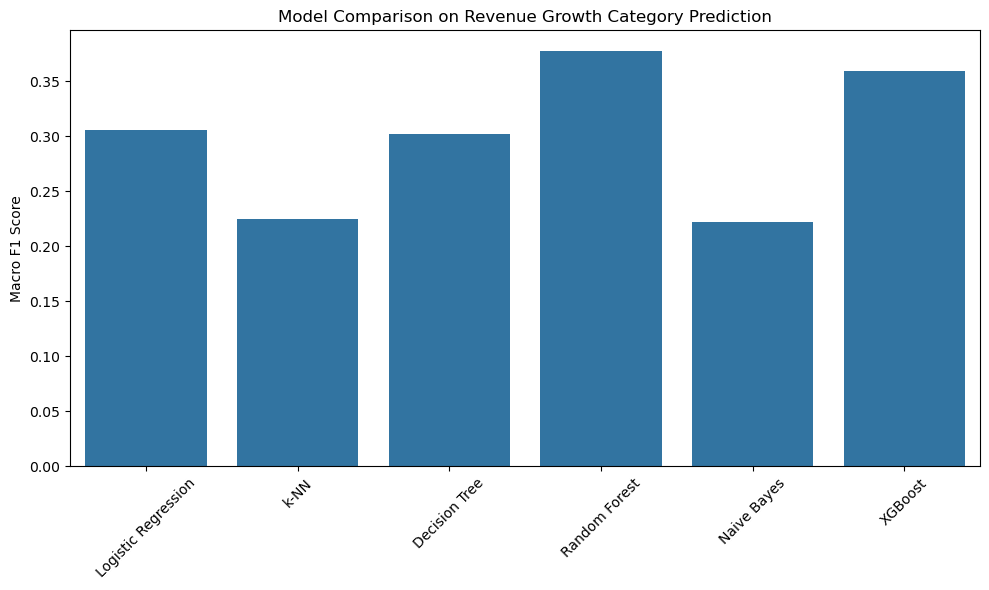

In [94]:
## Visualization of F1 Scores
plt.figure(figsize=(10, 6))
sns.barplot(x=list(scores.keys()), y=list(scores.values()))
plt.ylabel('Macro F1 Score')
plt.xticks(rotation=45)
plt.title('Model Comparison on Revenue Growth Category Prediction')
plt.savefig('../Image/Model_Comparison_F1.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

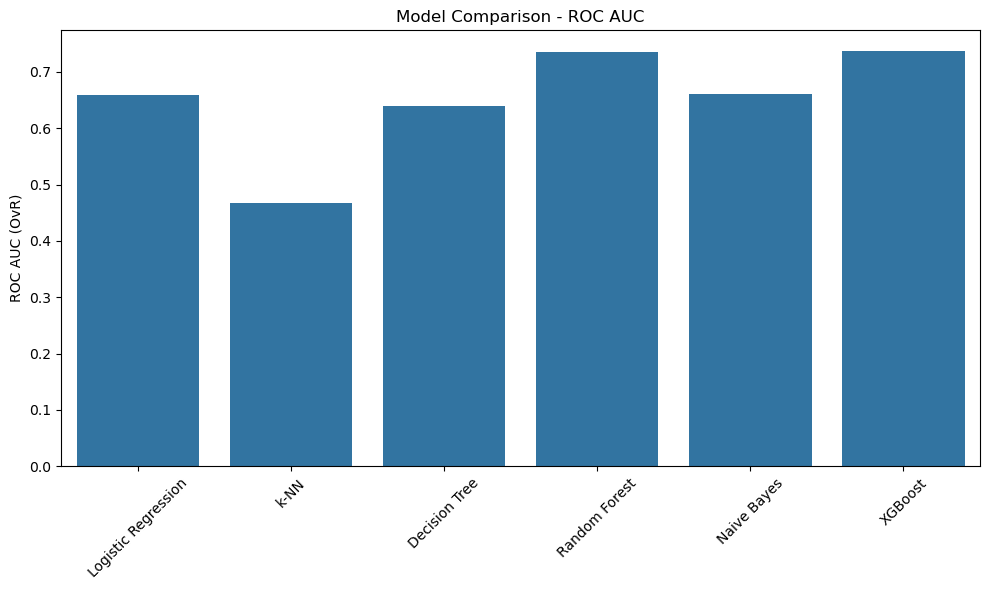

In [95]:
## Visualization of ROC AUC Scores
plt.figure(figsize=(10, 6))
sns.barplot(x=list(roc_aucs.keys()), y=list(roc_aucs.values()))
plt.ylabel('ROC AUC (OvR)')
plt.xticks(rotation=45)
plt.title('Model Comparison - ROC AUC')
plt.tight_layout()
plt.savefig('../Image/Model_Comparison_ROC.png', dpi=300, bbox_inches='tight')
plt.show()